<a href="https://colab.research.google.com/github/swapneel999/Major-Project-Pneumonia-Classifier/blob/main/Pneumonia_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following python program classifies X-rays of patients and determines whether the said patient has Pneumonia or not.

The model used is Inception_v3 which yields a good testing and training accuracy. 

The model is also deployed as a webapp using streamlit.

In [1]:
#Getting the Dataset
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"swapneelm99","key":"aaca50951ba4d2f3017a4b22ed9dfdd0"}'}

In [3]:
 ! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

 99% 2.27G/2.29G [01:10<00:00, 34.7MB/s]
100% 2.29G/2.29G [01:10<00:00, 34.9MB/s]


In [ ]:
! mkdir dataset
! unzip chest-xray-pneumonia.zip -d dataset

In [8]:
#Preprocessing the Dataset
# Importing the necessary libraries

import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [9]:
#Data Augmentation
train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, 
                                  width_shift_range = 0.2, height_shift_range = 0.2, 
                                 shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale=1./255.)

validation_datagen = ImageDataGenerator(rescale=1./255.)

In [10]:
training_set = train_datagen.flow_from_directory('/content/dataset/chest_xray/train',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'binary')
test_set = test_datagen.flow_from_directory('/content/dataset/chest_xray/test',
                                            target_size = (150, 150),
                                            batch_size = 32,
                                            class_mode = 'binary')

val_set = validation_datagen.flow_from_directory('/content/dataset/chest_xray/val',
                                            target_size = (150, 150),
                                            batch_size = 32,
                                            class_mode = 'binary')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [11]:
# Using the model InceptionV3
from keras.applications.inception_v3 import InceptionV3 

In [12]:
base_model = InceptionV3(include_top=False, weights='imagenet',input_shape=(150,150,3))

87916544/87910968 [==============================] - 2s 0us/step


In [13]:
# All the layers of the model should not necessarily be trainable and hence we only change the last layer
for layers in base_model.layers:
  layers.trainable=False

In [14]:
from tensorflow.keras import models,layers
x = base_model.output
x = layers.Flatten()(base_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.BatchNormalization()(x)
#x = layers.Dropout(0.2)(x)
x = layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.models.Model(base_model.input, x)

In [15]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [16]:
model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])

In [17]:
inc_history = model.fit(training_set, validation_data = test_set, epochs = 10)


Epoch 1/10
163/163 [==============================] - 97s 595ms/step - loss: 0.3530 - accuracy: 0.8710 - val_loss: 0.4175 - val_accuracy: 0.8413
Epoch 2/10
163/163 [==============================] - 95s 585ms/step - loss: 0.2083 - accuracy: 0.9202 - val_loss: 0.3437 - val_accuracy: 0.8766
Epoch 3/10
163/163 [==============================] - 95s 586ms/step - loss: 0.1950 - accuracy: 0.9202 - val_loss: 0.7924 - val_accuracy: 0.7564
Epoch 4/10
163/163 [==============================] - 95s 581ms/step - loss: 0.1870 - accuracy: 0.9247 - val_loss: 0.3015 - val_accuracy: 0.8830
Epoch 5/10
163/163 [==============================] - 95s 585ms/step - loss: 0.1976 - accuracy: 0.9193 - val_loss: 0.3240 - val_accuracy: 0.8702
Epoch 6/10
163/163 [==============================] - 96s 587ms/step - loss: 0.1800 - accuracy: 0.9281 - val_loss: 0.3225 - val_accuracy: 0.8798
Epoch 7/10
163/163 [==============================] - 96s 587ms/step - loss: 0.1737 - accuracy: 0.9300 - val_loss: 0.3876 - val_ac

In [18]:
result  = model.evaluate(test_set, steps=len(test_set), verbose=1)
print('Loss:', result[0])
print('Accuracy:', result[1])

20/20 [==============================] - 6s 316ms/step - loss: 0.3668 - accuracy: 0.8574
Loss: 0.36684083938598633
Accuracy: 0.8573718070983887


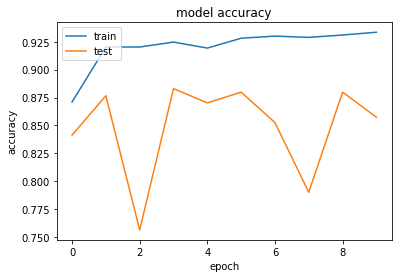

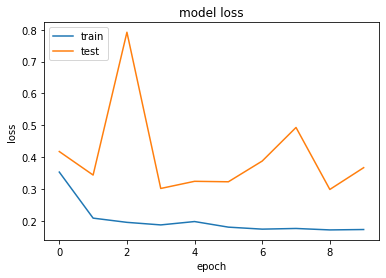

In [19]:
plt.plot(inc_history.history['accuracy'])
plt.plot(inc_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(inc_history.history['loss'])
plt.plot(inc_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

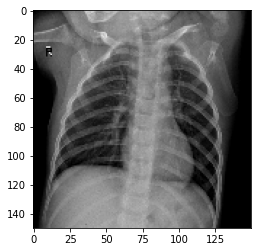

In [20]:
from keras.preprocessing import image
x = image.load_img('/content/dataset/chest_xray/val/NORMAL/NORMAL2-IM-1442-0001.jpeg',target_size=(150,150))
plt.imshow(x)

In [21]:
import numpy as np
from keras.applications.inception_v3 import preprocess_input,decode_predictions 

x_resize = image.img_to_array(x)
print(x_resize.shape)
x_resize = np.expand_dims(x_resize,axis =0)
print(x_resize.shape)
x_final = preprocess_input(x_resize)

(150, 150, 3)
(1, 150, 150, 3)


In [22]:
predictions = model.predict(x_final)
print(predictions)
predictions = predictions.reshape(1,-1)[0]
predictions[predictions >= 0.5] = 1
predictions[predictions < 0.5] = 0
predictions

[[0.03467136]]


array([0.], dtype=float32)

In [23]:
if predictions==0:
  print('The chest x-ray is normal')
else:
  print('The chest x-ray shows Pneumonia')

The chest x-ray is normal


In [24]:
model.save('pneumonia.h5')

In [25]:
!pip install streamlit

!pip install pyngrok
import pyngrok

     |████████████████████████████████| 7.4MB 2.8MB/s 
     |████████████████████████████████| 6.7MB 38.8MB/s 
     |████████████████████████████████| 4.4MB 44.4MB/s 
     |████████████████████████████████| 112kB 43.4MB/s 
     |████████████████████████████████| 163kB 40.9MB/s 
     |████████████████████████████████| 102kB 10.8MB/s 
     |████████████████████████████████| 133kB 42.0MB/s 
     |████████████████████████████████| 122kB 41.3MB/s 
     |████████████████████████████████| 71kB 8.8MB/s 
     |████████████████████████████████| 71kB 8.1MB/s 
  Created wheel for blinker: filename=blinker-1.4-cp36-none-any.whl size=13450 sha256=e05188de218c6c277758116c5657896ebcecdba49558eaf5ec74af50c3aac903
  Stored in directory: /root/.cache/pip/wheels/92/a0/00/8690a57883956a301d91cf4ec999cc0b258b01e3f548f86e89
  Created wheel for watchdog: filename=watchdog-0.10.3-cp36-none-any.whl size=73873 sha256=dda750210cdcdec2121270154d9f11ca19947892505243c1835e63863a07fe4d
  Stored in directory: /root/.c

  Created wheel for pyngrok: filename=pyngrok-4.2.2-cp36-none-any.whl size=18025 sha256=6a9a7be9ab5477dbae87e9050be5bbd73583387441d742ed0d2d62b561c697ca
  Stored in directory: /root/.cache/pip/wheels/9c/d3/b5/502fbef4b2782a6142bc00c62ccde76ee04c9148fb43b1b2cd
Successfully built pyngrok


In [28]:
%%writefile app.py
import numpy as np
import streamlit as st
from skimage.io import imread
from skimage.transform import resize
from PIL import Image
import tensorflow as tf
from keras.applications.inception_v3 import preprocess_input,decode_predictions
from keras.preprocessing import image
import os


st.set_option('deprecation.showfileUploaderEncoding',False)
st.title("Pneumonia Detector")
st.text("Upload your image")

model = tf.keras.models.load_model('pneumonia.h5')
uploaded_file = st.file_uploader("Choose the image...", type = 'jpg')



if uploaded_file is not None:


  img = Image.open(uploaded_file)
  img = img.resize((300,250))
  st.image(img, caption = "Uploaded Image")

  st.write("")

  if st.button('Predict'):
    st.write('Result..')
    img = image.img_to_array(img)
    img = resize(img,(150,150,3), anti_aliasing = True, mode = 'reflect')
    img = np.expand_dims(img,axis =0)
    img = preprocess_input(img)
    predictions = model.predict(img)
    predictions = predictions.reshape(1,-1)[0]
    predictions[predictions >= 0.5] = 1
    predictions[predictions < 0.5] = 0
    if predictions==0:
      y_out= 'The chest x-ray is normal'
    else:
      y_out='The chest x-ray shows Pneumonia'
    st.title(f"Predicted output:{y_out}")

Overwriting app.py


In [27]:
from pyngrok import ngrok
!nohup streamlit run app.py &

public_url = ngrok.connect(port = '8501')
print(public_url)

nohup: appending output to 'nohup.out'
http://985fa984a7b1.ngrok.io


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Support for "return_ngrok_tunnel" as "False" is deprecated and will be removed in 5.0.0, when this method will return a NgrokTunnel instead of a str
  after removing the cwd from sys.path.
